### **Imports & Getting the Data**

In [1]:
import pandas as pd 
import nltk
import re
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
wnl = WordNetLemmatizer()
sns.set_style('darkgrid')
sns.set_palette('mako')

In [2]:
df = pd.read_excel("tweet_cluster3.xlsx", index_col = None, na_values = ['NA'], usecols = 'F, O:AB, AH') # getting only the columns that are needed
df = df.fillna(0) # filling the NaN values with 0
df.iloc[:, 2:] = df.iloc[:, 2:].astype(int) # converting the values to int
df.loc[df['cause'] == 98, 'Uncategorized 99'] = 1 # converting invalid cause 98 to Uncategorized 99
df['cause'] = df['cause'].replace(98, 99) 

### **Data/text pre-processing**

In [3]:
# renaming the columns to make it easier to work with
rename_cols_dict = {
    'Twitter @ Name' : '@name',
    'Tweet_tokenized' : 'tweet',
    'Covid 19: China Virus 1' : '1',
    'Anti-Asian Racism 2' : '2',
    'Xenophobia (insulting foreigners: invasion) 3' : '3',
    'Anti-Black racism 4' : '4',
    'Islamophobia 5' : '5',
    'White identity politics (white supremacy, great replacement theory, denuncing white genocide and multiculturalism, deconstruction of white privilege) 6' : '6',
    'Pro-Trump, republican, patriot (?), Trump rhetoric (ex: Fakenews) 7' : '7',
    'Pro-Wall or/and Anti-immigration 8' : '8',
    'Elections/governmental politics 9' : '9',
    'Antifa, denunciation of white privilege, anti-Trump, Nashville explosion label, 10' : '10',
    'Calls for Action 11' : '11',
    'Non-US: South Africa, UK, 12' : '12',
    'Uncategorized 99' : '99',
    }
df.rename(columns = rename_cols_dict, inplace = True)

In [4]:
# tweets not really stored as lists, so converting them to lists
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['tweet'] = df['tweet'].apply(lambda x: x.strip())

In [5]:
# Edit accordingly but takes a while to run
pos_tags = ["ADJ", "NOUN", "VERB"]
# Function to lemmatize the tweets
def lemmatize_with_tag(text, pos_tags = pos_tags):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    tagged_text = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ in pos_tags:
            tagged_text.append(token.lemma_)
        else:
            tagged_text.append(token.text)
    return(' '.join(tagged_text))

In [6]:
# Storing stop words as a list
remove_stop_words = stopwords.words('english')

In [7]:
# Explicitly removing stopwords
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (remove_stop_words)]))
# Lemmatizing the tweets with POS tagging
df['tweet'] = df['tweet'].apply(lambda x: lemmatize_with_tag(x))

### **Exploratory Data Analysis**

In [8]:
df.head(10).style.applymap(lambda x: 'background-color: maroon' if x == 1 else '')

,@name,tweet,1,2,3,4,5,6,7,8,9,10,11,12,99,cause
0,LadyRedWave,ppl suppose welcome open arm think buildthewall,0,0,0,0,0,0,0,1,0,0,0,0,0,8
1,almostjingo,pretty safe say catch release ag session lay law border buildthewall,0,0,0,0,0,0,0,1,0,0,0,0,0,8
2,almostjingo,pretty safe say catch release ag session lay law border buildthewall,0,0,0,0,0,0,0,1,0,0,0,0,0,8
3,CortesSteve,border wall protect america jobs arizona win win chalktalk buildthewall,0,0,0,0,0,0,0,1,0,0,0,0,0,8
4,CortesSteve,border wall protect america jobs arizona win win chalktalk buildthewall,0,0,0,0,0,0,0,1,0,0,0,0,0,8
5,ianbremmer,trump 2016 buildthewall biden 2020 countthemall,0,0,0,0,0,0,0,1,0,0,0,0,0,8
6,ianbremmer,trump 2016 buildthewall biden 2020 countthemall,0,0,0,0,0,0,0,1,0,0,0,0,0,8
7,LadyRedWave,excellent keep go make long amp tall buildthewall protectamericansovereignty protectourborder section,0,0,0,0,0,0,0,1,0,0,0,0,0,8
8,LadyRedWave,excellent keep go make long amp tall buildthewall protectamericansovereignty protectourborder section,0,0,0,0,0,0,0,1,0,0,0,0,0,8
9,ChitownJewrean1,look americafirst buildthewall secureourborder trumprally rsbn dictionary see blake,0,0,0,0,0,0,0,1,0,0,0,0,0,8


In [9]:
# Understanding the distribution of the tweets across the categories
df['tweet'].value_counts()[:2661]

17 reason deport many problem even get hand really want keep                                763
wonder many people blame borisjohnson covid buying good make china whilst world struggle    267
ask china pay 2 trillion cost chinesevirus                                                  223
ppl suppose welcome open arm think buildthewall protectourborder pro                        219
pretty safe say catch release ag session lay law border buildthewall protectou              153
                                                                                           ... 
china motherland almost deadly virus world chinavirus                                         1
agree brother buildthewall                                                                    1
really chinavirus publicenemy                                                                 1
buildthewall keep illegalalien                                                                1
trump2020 ripgrumpycat remember must go 

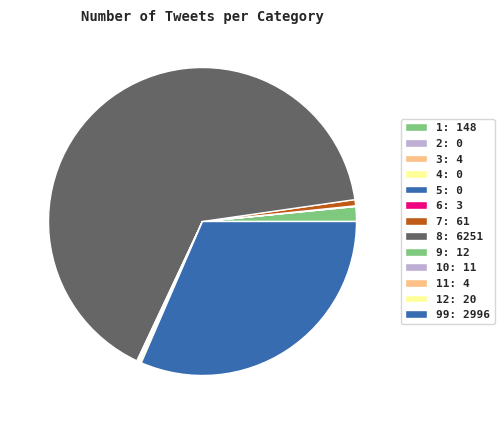

In [67]:
# Plotting graph of number of tweets per category using piechart
fig, ax = plt.subplots(figsize = (5, 5))
labels = df.columns[2:15]
sizes = df.iloc[:, 2:15].sum().values
labels = [f'{labels[i]}: {sizes[i]}' for i in range(len(labels))]
df.iloc[:, 2:15].sum().plot(kind = 'pie', ax = ax, colors = sns.color_palette('Accent'), labels = None)
ax.set_title('Number of Tweets per Category', fontsize = 10, fontweight = 'bold')
ax.set_ylabel('')
ax.legend(labels = labels, loc = 'center left', bbox_to_anchor = (1, 0.5), fontsize = 8)
plt.show()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
# Get top n words for any corpus
def get_top_n_words(corpus, n = None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

In [13]:
# Function to make top n words for a given feature and target
def make_top_n_words(df, text_col, target_col, n = None):
    list_of_targets = df[target_col].sort_values().unique().tolist()
    indices = [df[df[target_col] == cat].index.values.tolist() for cat in list_of_targets]
    corpus = [df.loc[index][text_col].tolist() for index in indices]
    top_n_words = [get_top_n_words(text, n) for text in corpus]
    return top_n_words

In [14]:
# Getting the top 20 words for each category
top_20_w_per_cat = make_top_n_words(df, 'tweet', 'cause', 10)

In [15]:
# Getting unique column names that are used
columns = np.unique(df['cause'])

<Figure size 1000x1000 with 0 Axes>

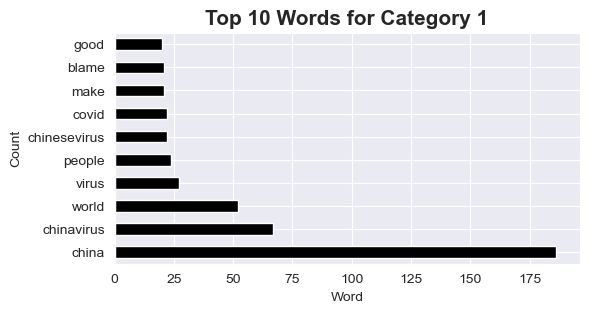

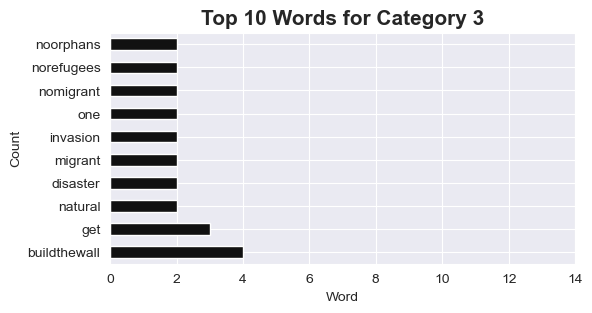

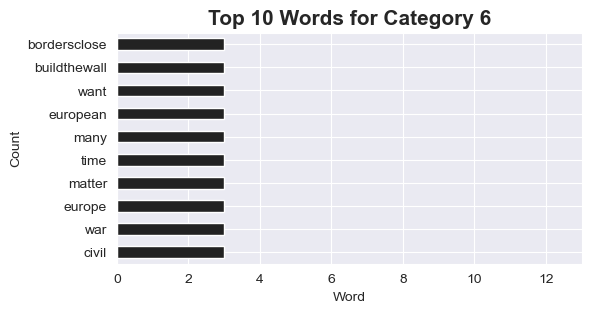

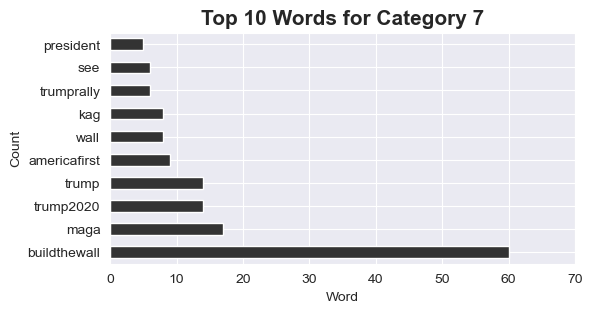

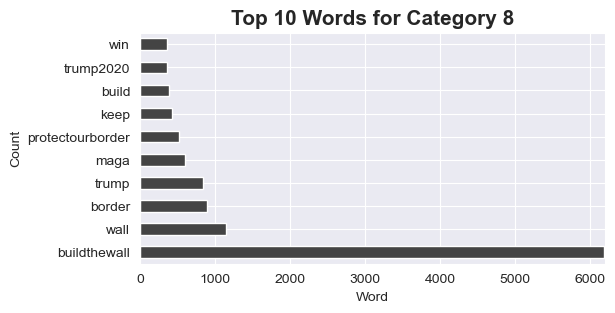

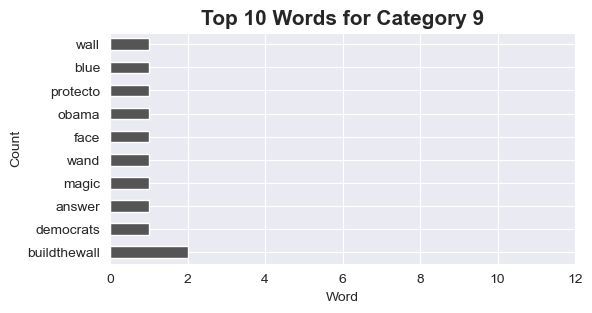

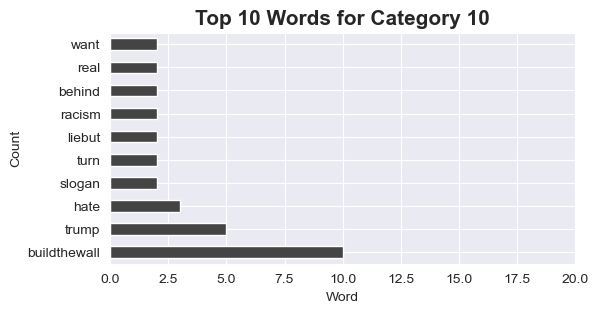

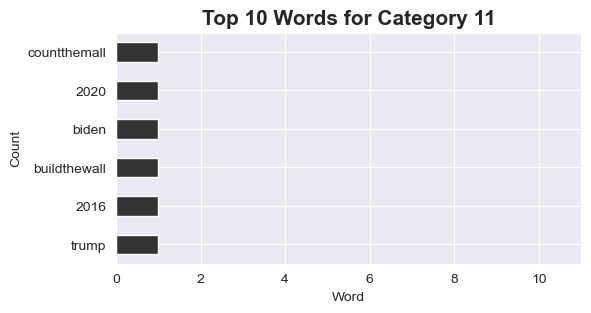

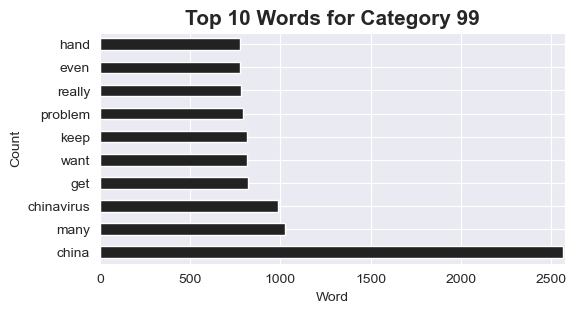

In [16]:
# Plotting the top 20 words for each category
plt.figure(figsize = (10, 10), facecolor='w')
colors = ['#000', '#111', '#222', '#333', '#444', '#555', '#444', '#333', '#222']
for col in range(len(columns)):
    fig, ax = plt.subplots(figsize = (6, 3))
    df_top_10 = pd.DataFrame(top_20_w_per_cat[col], columns = ['word', 'count'])
    df_top_10.plot(kind = 'barh', x = 'word', y = 'count', ax = ax, color = colors[col])
    ax.set_title(f'Top 10 Words for Category {columns[col]}', fontsize = 15, fontweight = 'bold')
    ax.set_xlim(right = df_top_10['count'].max() + 10)
    ax.set_ylabel('Count')
    ax.set_xlabel('Word')
    ax.legend().set_visible(False)
    plt.show()

In [17]:
import multiprocessing
# Counts the number of cores in the computer
cores = multiprocessing.cpu_count()
cores

8

In [18]:
# Getting words from descriptions
word_sent_list = []
for sent in df['tweet']:
    word_sent_list.append(sent.split())

In [19]:
w2v_model = Word2Vec(word_sent_list, workers = cores - 1, min_count = 1, vector_size = 100, window = 3, epochs = 1000)
w2v_tweets = []
# Getting the average word vectors for each description
for sent in word_sent_list:
    sent_vec = np.zeros(100)
    cnt_words = 0
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1 
        except:
            pass
    sent_vec /= cnt_words 
    w2v_tweets.append(sent_vec)
w2v_tweets = np.array(w2v_tweets)
w2v_tweets = np.nan_to_num(w2v_tweets)

In [20]:
from gensim.models.phrases import Phrases, Phraser
from sklearn.manifold import TSNE

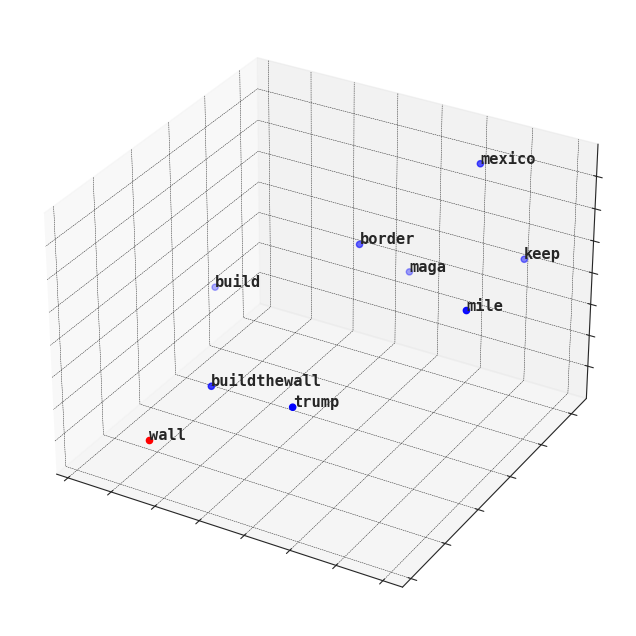

In [60]:
# Plotting a 3d scatter plot of most similar words
word = "wall"
fig = plt.figure(figsize = (8, 8))
tot_words = [word] + [tupla[0] for tupla in 
                 w2v_model.wv.most_similar(word, topn = 8)]
X = w2v_model.wv[tot_words]
pca = TSNE(n_components=3, random_state=0, perplexity = 8)
X = pca.fit_transform(X)
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 11, 'font.family': 'monospace', 'font.weight': 'bold'})
plt.rcParams.update({'grid.color': '#000', 'grid.linestyle': '--', 'grid.linewidth': 0.3})
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="blue")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [103]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, log_loss, confusion_matrix, cohen_kappa_score, matthews_corrcoef

In [115]:
# Function to get evaluation scores
def evaluate_model(y_test, y_pred, y_pred_proba):
    acc = accuracy_score(y_test, y_pred.round())
    prec = precision_score(y_test, y_pred.round(), average = 'weighted')
    rec = recall_score(y_test, y_pred.round(), average = 'weighted')
    f1 = f1_score(y_test, y_pred.round(), average = 'weighted')
    logloss = log_loss(y_test, y_pred_proba)
    kappa = cohen_kappa_score(y_test, y_pred.round())
    mcc = matthews_corrcoef(y_test, y_pred.round())
    return acc, prec, rec, f1, logloss, kappa, mcc

In [116]:
# Function to store the results of the models as a dataframe
def store_results(model_name, params, y_test, y_pred, y_pred_proba):
    acc, prec, rec, f1, logloss, kappa, mcc = evaluate_model(y_test, y_pred, y_pred_proba)
    results = pd.DataFrame([[model_name, params, acc, prec, rec, f1, logloss, kappa, mcc]], 
                           columns = ['model', 'params', 'accuracy', 'precision', 'recall', 'f1', 'logloss', 'kappa', 'mcc'])
    return results

In [117]:
# Oversampling the minority class
ros = RandomOverSampler(random_state=42)
x1, y1 = ros.fit_resample(w2v_tweets, df['cause'])

In [118]:
# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size = 0.3, random_state = 42)

In [119]:
import optuna

In [120]:
list_of_dfs = []
# Function to optimize the hyperparameters of the model
def objective(trial):
      classifier_name = trial.suggest_categorical("classifier", ["RandomForest", "XGB"])
      if classifier_name == "RandomForest":
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            n_estimators = trial.suggest_int('n_estimators', 50, 500)
            max_depth = int(trial.suggest_loguniform('max_depth', 2, 32))
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15)
            max_features = trial.suggest_int('max_features', 1, 3)
            params = {
                  "criterion": criterion,
                  "n_estimators": n_estimators,
                  "max_depth": max_depth,
                  "min_samples_split": min_samples_split,
                  "min_samples_leaf": min_samples_leaf,
                  "max_features": max_features
            }
            clf = RandomForestClassifier(criterion = criterion, n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, max_features = max_features)
      else:
            booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
            reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-3, 10.0)
            reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-3, 10.0)
            subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
            max_depth = int(trial.suggest_loguniform("max_depth", 2, 32))
            params = {
                  "booster": booster,
                  "reg_alpha": reg_alpha,
                  "reg_lambda": reg_lambda,
                  "subsample": subsample,
                  "max_depth": max_depth
            }
            clf = XGBClassifier(eval_metric = "mlogloss", booster = booster, reg_alpha = reg_alpha, reg_lambda = reg_lambda, subsample = subsample, max_depth = max_depth)

      clf.fit(x_train, y_train)
      pred = clf.predict(x_test)
      pred_proba = clf.predict_proba(x_test)
      results = store_results(classifier_name, params, y_test, pred, pred_proba)
      list_of_dfs.append(results)
      
      return f1_score(y_test, pred.round(), average = 'weighted')

In [123]:
# Creating the study object and optimizing the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2022-12-07 16:04:29,000] A new study created in memory with name: no-name-ca51b1f9-9859-42e9-87d1-68a7b4bd5ec6
[I 2022-12-07 16:04:31,580] Trial 0 finished with value: 0.9450586803994843 and parameters: {'classifier': 'RandomForest', 'criterion': 'entropy', 'n_estimators': 137, 'max_depth': 31.16637835379995, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 2}. Best is trial 0 with value: 0.9450586803994843.


[16:04:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "max_depth", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-07 16:04:37,826] Trial 1 finished with value: 0.8098812051368911 and parameters: {'classifier': 'XGB', 'booster': 'gblinear', 'reg_alpha': 0.004658737326919441, 'reg_lambda': 0.3741377281287462, 'subsample': 0.7570257489079061, 'max_depth': 2.47564471327984}. Best is trial 0 with value: 0.9450586803994843.
[I 2022-12-07 16:06:29,234] Trial 2 finished with value: 0.9460103267148225 and parameters: {'classifier': 'XGB', 'booster': 'dart', 'reg_alpha': 0.3516488457192695, 'reg_lambda': 0.11396142960872553, 'subsample': 0.14894136141399833, 'max_depth': 9.221753960511235}. Best is trial 2 with value: 0.9460103267148225.
[I 2022-12-07 16:06:36,517] Trial 3 finished with value: 0.9450505295841759 and parameters: {'classifier': 'RandomForest', 'criterion': 'log_loss', 'n_estimators': 412, 'max_depth': 28.12496680600582, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 2}. Best is trial 2 with value: 0.9460103267148225.


[16:06:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "max_depth", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-07 16:06:39,085] Trial 4 finished with value: 0.021416926041203495 and parameters: {'classifier': 'XGB', 'booster': 'gblinear', 'reg_alpha': 1.646225628508589, 'reg_lambda': 0.21953324954479755, 'subsample': 0.8165236310492909, 'max_depth': 16.174328689005623}. Best is trial 2 with value: 0.9460103267148225.
[I 2022-12-07 16:06:48,329] Trial 5 finished with value: 0.9444171552817706 and parameters: {'classifier': 'RandomForest', 'criterion': 'log_loss', 'n_estimators': 423, 'max_depth': 11.785553770049376, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 3}. Best is trial 2 with value: 0.9460103267148225.
[I 2022-12-07 16:08:43,152] Trial 6 finished with value: 0.9460757797058775 and parameters: {'classifier': 'XGB', 'booster': 'dart', 'reg_alpha': 0.02462482957491286, 'reg_lambda': 0.0379940009175887, 'subsample': 0.21423887924537433, 'max_depth': 9.662372747597061}. Best is trial 6 with value: 0.9460757797058775.
[I 2022-12-07 16:08:59,212] Trial 7 finished w

[16:08:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "max_depth", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-07 16:09:01,172] Trial 8 finished with value: 0.021416926041203495 and parameters: {'classifier': 'XGB', 'booster': 'gblinear', 'reg_alpha': 2.487037589546192, 'reg_lambda': 0.3326811004059107, 'subsample': 0.4364293721676722, 'max_depth': 9.125694623061966}. Best is trial 7 with value: 0.9466372576829252.
[I 2022-12-07 16:09:02,259] Trial 9 finished with value: 0.9446341504224173 and parameters: {'classifier': 'RandomForest', 'criterion': 'entropy', 'n_estimators': 76, 'max_depth': 20.885566831122492, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 1}. Best is trial 7 with value: 0.9466372576829252.
[I 2022-12-07 16:09:19,019] Trial 10 finished with value: 0.9461611120071417 and parameters: {'classifier': 'XGB', 'booster': 'gbtree', 'reg_alpha': 0.0775785275816061, 'reg_lambda': 0.0010624226058388551, 'subsample': 0.55280462445242, 'max_depth': 3.959156962364549}. Best is trial 7 with value: 0.9466372576829252.
[I 2022-12-07 16:09:39,380] Trial 11 finished w

In [209]:
# Printing the best parameters and f1 score
trial = study.best_trial
print("Best hyperparameters: {}".format(trial.params))
print('F1 Score: {}'.format(trial.value))

Best hyperparameters: {'classifier': 'XGB', 'booster': 'gbtree', 'reg_alpha': 0.2774618761227754, 'reg_lambda': 0.00109327754030009, 'subsample': 0.6028534235775451, 'max_depth': 4.493821312629868}
F1 Score: 0.9471875261726915


In [125]:
# Finding important hyperparameters
optuna.visualization.plot_param_importances(study)

In [205]:
# Individually plotting the hyperparameter importance and study
optuna.visualization.plot_slice(study)

In [206]:
# Further understanding the study for given parameters
optuna.visualization.plot_slice(study, ['reg_alpha', 'subsample', 'reg_lambda'])

In [207]:
# Plotting the study history
optuna.visualization.plot_optimization_history(study)

In [150]:
# Getting the best parameters and f1 score for each model using optuna's best trial dataframe
opt_df = study.trials_dataframe().fillna('')
opt_df = opt_df.sort_values(by = 'value', ascending = False).groupby('params_classifier').head(1)
param_cols = [col for col in opt_df.columns if col.startswith('params_')]
opt_df = opt_df.rename(columns = {col: col.replace('params_', '') for col in param_cols})
opt_df

,number,value,datetime_start,datetime_complete,duration,booster,classifier,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,reg_alpha,reg_lambda,subsample,state
12,12,0.947188,2022-12-07 16:09:39.380564,2022-12-07 16:09:58.311179,0 days 00:00:18.930615,gbtree,XGB,,4.493821,,,,,0.277462,0.001093,0.602853,COMPLETE
0,0,0.945059,2022-12-07 16:04:29.001679,2022-12-07 16:04:31.580027,0 days 00:00:02.578348,,RandomForest,entropy,31.166378,2.0,11.0,2.0,137.0,,,,COMPLETE


In [151]:
# Concatenating list of dataframes
results_df = pd.concat(list_of_dfs)
results_df

,model,params,accuracy,precision,recall,f1,logloss,kappa,mcc
0,XGB,"{'booster': 'gbtree', 'reg_alpha': 0.170297591...",0.948658,0.957095,0.948658,0.947271,0.130238,0.942249,0.943720
0,RandomForest,"{'criterion': 'entropy', 'n_estimators': 234, ...",0.860412,0.900175,0.860412,0.843264,0.624378,0.843030,0.850921
0,RandomForest,"{'criterion': 'entropy', 'n_estimators': 137, ...",0.946382,0.950355,0.946382,0.945059,0.151834,0.939686,0.940546
0,XGB,"{'booster': 'gblinear', 'reg_alpha': 0.0046587...",0.823269,0.826551,0.823269,0.809881,0.919254,0.801247,0.805079
0,XGB,"{'booster': 'dart', 'reg_alpha': 0.35164884571...",0.947520,0.955912,0.947520,0.946010,0.128318,0.940969,0.942467
0,RandomForest,"{'criterion': 'log_loss', 'n_estimators': 412,...",0.946382,0.950356,0.946382,0.945051,0.152101,0.939686,0.940547
0,XGB,"{'booster': 'gblinear', 'reg_alpha': 1.6462256...",0.108974,0.011875,0.108974,0.021417,2.197331,0.000000,0.000000
0,RandomForest,"{'criterion': 'log_loss', 'n_estimators': 423,...",0.946441,0.955559,0.946441,0.944417,0.169805,0.939756,0.941381
0,XGB,"{'booster': 'dart', 'reg_alpha': 0.02462482957...",0.946981,0.950931,0.946981,0.946076,0.128394,0.940360,0.941152
0,XGB,"{'booster': 'gbtree', 'reg_alpha': 0.504013664...",0.948179,0.956367,0.948179,0.946637,0.123559,0.941710,0.943159


In [153]:
# Getting only the best scores for each model
results_df = results_df.sort_values(by = ['f1', 'kappa', 'mcc'], ascending = False).groupby('model').head(1)
results_df

,model,params,accuracy,precision,recall,f1,logloss,kappa,mcc
0,XGB,"{'booster': 'gbtree', 'reg_alpha': 0.170297591...",0.948658,0.957095,0.948658,0.947271,0.130238,0.942249,0.943720
0,RandomForest,"{'criterion': 'entropy', 'n_estimators': 137, ...",0.946382,0.950355,0.946382,0.945059,0.151834,0.939686,0.940546


In [203]:
# Function for plotting all the metrics for all the models
def plot_metrics(metrics_list, title, x_ticks, no_of_ticks = 2, y_lim = (0, 1)):
    df_metrics = pd.DataFrame(metrics_list, columns = ['accuracy', 'precision', 'recall', 'f1', 'kappa', 'mcc'])
    sns.set_palette('RdPu')
    df_metrics.plot(kind = 'bar', figsize = (22, 12))
    for p in plt.gca().patches:
        plt.gca().annotate('{:.2%}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', fontsize = 11, color = '#000', xytext = (0, 10), textcoords = 'offset points', fontweight = 'bold')
    plt.title(title, fontsize = 16, fontweight = 'bold', pad = 15)
    plt.xticks(np.arange(no_of_ticks), x_ticks, rotation = 0)
    plt.ylim(y_lim)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 11)
    plt.legend(labelcolor = '#fff', loc = 'lower right', fontsize = 12, facecolor = '#000', edgecolor = '#fff', framealpha = 0.9, fancybox = True, shadow = True, borderpad = 2)
    plt.show()

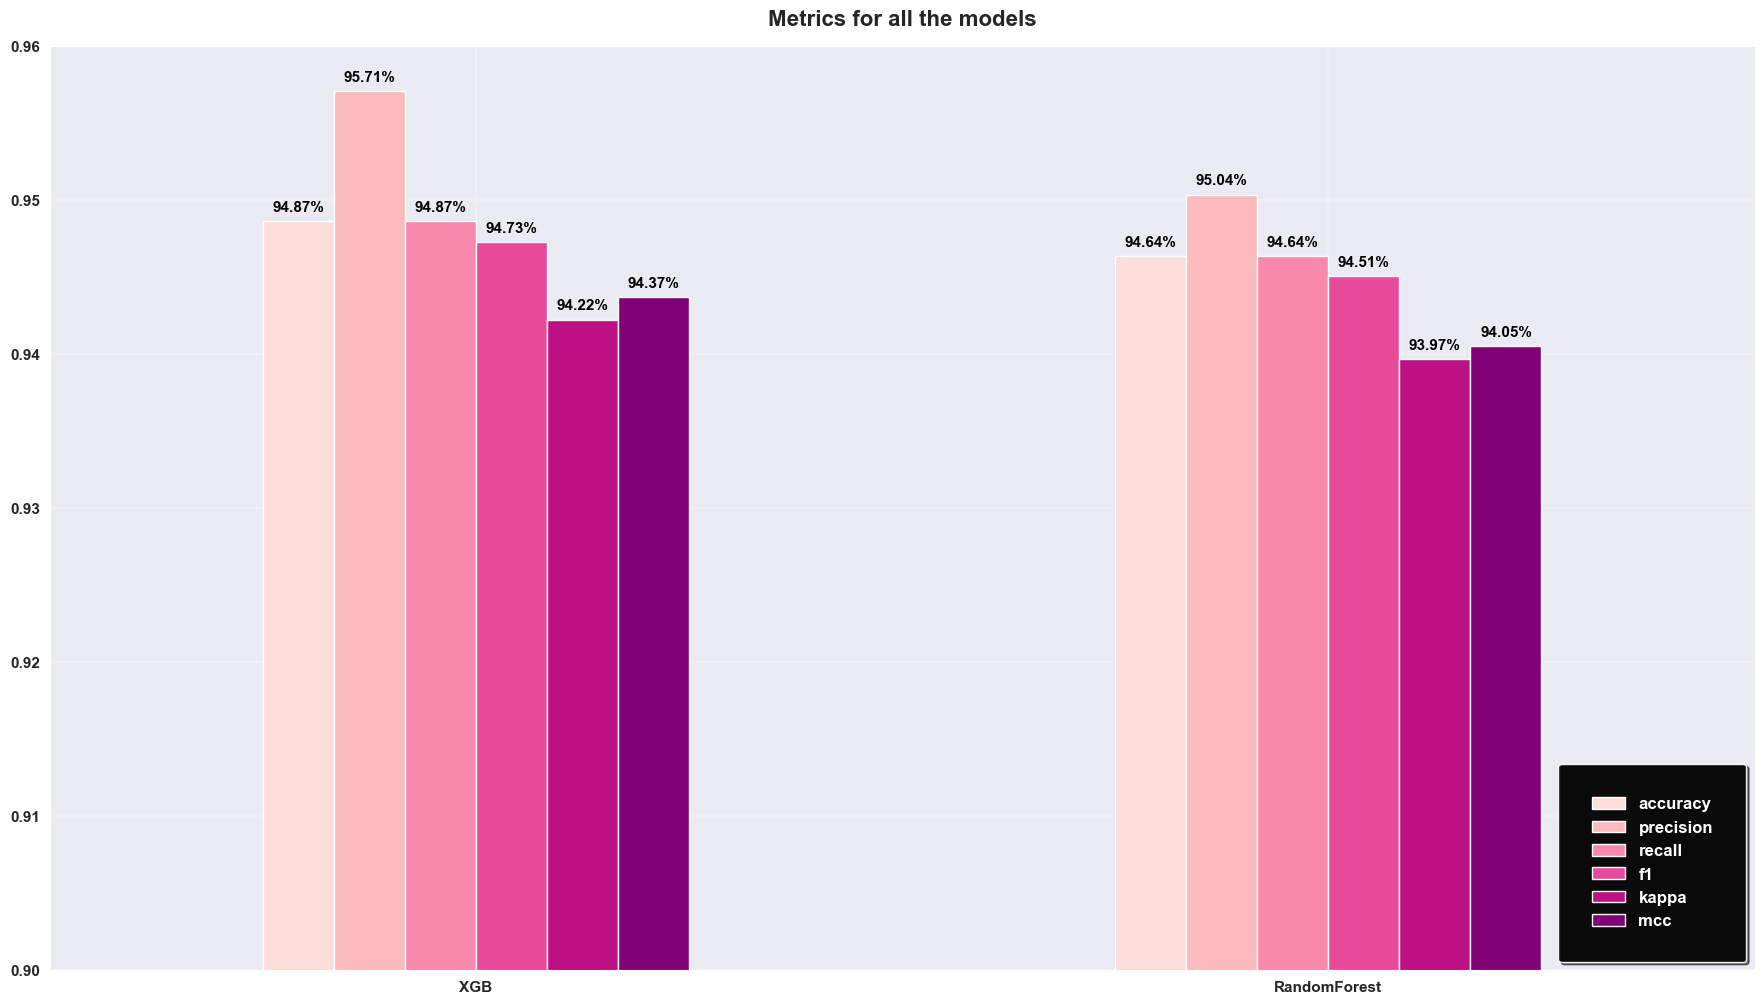

In [204]:
# Getting metrics for each model
metrics_list = []
model_names = ['XGB', 'RandomForest']
for model in model_names:
    model_df = results_df[results_df['model'] == model]
    metrics_list.append(model_df[['accuracy', 'precision', 'recall', 'f1', 'kappa', 'mcc']].values.tolist()[0])
# Plotting metrics for each model
# Second last parameter is the number of classifiers on x-axis, last parameter is the y-axis limit (default is (0, 1))
plot_metrics(metrics_list, 'Metrics for all the models', model_names, 2, (0.90, 0.96))